In [1]:
import numpy as np
from collections import defaultdict

from iq.iq import score
from nvd_entry import NVDEntry
from utils import get_cve_list

In [2]:
def get_metrics(scores):
    completeness_per_year = {y:d['cm_score'] for y,d in scores.items()}
    accuracy_per_year = {y:d['am_score'] for y,d in scores.items()}
    uniqueness_per_year = {y:d['um_score'] for y,d in scores.items()}
    
    return {'Completeness': completeness_per_year, 
            'Accuracy': accuracy_per_year, 
            'Uniqueness': uniqueness_per_year}

In [3]:
figsize = (5,8)
figheight = figsize[0]
figwidth = figsize[1]

In [4]:
plot_colors1 = {'Uniqueness': '#3080b8',
               'Accuracy': '#ff7f0e',
               'Completeness': '#2ca02c'}

plot_colors2 = {'Uniqueness': '#1d6496',
               'Accuracy': '#ff7f0e',
               'Completeness': '#2ca02c'}

plot_colors3 = {'Uniqueness': '#0a4670',
               'Accuracy': '#ff7f0e',
               'Completeness': '#2ca02c'}

def get_color(label, index):
    if index == 0:
        return plot_colors1[label]
    if index == 1:
        return plot_colors2[label]
    if index == 2:
        return plot_colors3[label]

In [5]:
def plot_stacked(metrics_list: list):
    years = metrics_list[0][[*metrics_list[0].keys()][0]].keys()
    xticklabels = [y if int(y) % 5 == 0 else '' for y in years]
    x = np.arange(len(xticklabels))

    fig, ax = plt.subplots()
    width = 0.8
    
    num_metrics = len(metrics_list)

    for i, metrics in enumerate(metrics_list):
        pos = x - width/num_metrics + i*width/num_metrics + (num_metrics+1)%2 * width/(2*num_metrics) # works now for 2 and 3
        offset = np.zeros(len(years))
        this_width = width/len(metrics_list)
        
        for label, metric in metrics.items():
            data = list(metric.values())
            ax.bar(pos, data, this_width, bottom=offset, label=label, color=get_color(label, i))
            offset += data

        avg = sum(offset)/len(years)
    
    ax.set_xticks(x)
    ax.set_xticklabels(xticklabels)
    ax.legend()
    ax.set_ylabel(f'IQ score')
    
    fig.set_figheight(figheight)
    fig.set_figwidth(figwidth)
    
    plt.grid(linestyle='-', linewidth=1, axis='y', alpha=0.15)

    plt.show()

In [6]:
import matplotlib.pyplot as plt

def side_by_side_barplot(metrics: dict, ylabel):
    years = metrics[[*metrics.keys()][0]].keys()
    num_metrics = len(metrics)
    xticklabels = [label if int(label) % 5 == 0 else '' for label in years]
    x = np.arange(len(xticklabels))
    
    fig, ax = plt.subplots()
    width = 0.8
    
    ax.set_xticks(x)
    ax.set_xticklabels(xticklabels)
    for i, (label, metric) in enumerate(metrics.items()):
        pos = x - width/num_metrics + i*width/num_metrics + (num_metrics+1)%2 * width/(2*num_metrics) # works now for 2 and 3
        data = metric.values()
        ax.bar(pos, data, width/num_metrics, label=label)

    ax.set_ylabel(f'{ylabel} score')
    ax.legend()
    
    plt.grid(linestyle='-', linewidth=1, axis='y', alpha=0.15)
    
    fig.set_figheight(figheight)
    fig.set_figwidth(figwidth)
    
    plt.show()

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

def plot_metric(metric: dict, label: str, normalize=False):
    xticklabels = [label if int(label) % 5 == 0 else '' for label in metric.keys()]
    x = np.arange(len(xticklabels))
    if normalize:
        norm = Normalize(0, max(metric.values()))
    
    fig, ax = plt.subplots()
    width = 0.8

    ax.set_xticks(x)
    ax.set_xticklabels(xticklabels)
    ax.bar(x, list(map(norm, metric.values())) if normalize else metric.values(), width, color=get_color(label,0))
    ax.set_ylabel(f'{label} score{" normalized" if normalize else ""}')
    
    avg = sum(metric.values())/len(metric)
    print(avg)
    ax.axhline(avg, linewidth=1, alpha=0.5, color='black', label='Average')
    
    plt.grid(linestyle='-', linewidth=1, axis='y', alpha=0.15)
    ax.legend()
    
    fig.set_figheight(figheight)
    fig.set_figwidth(figwidth)

    plt.show()

# Original Database

### Database timestamp

In [8]:
from utils import get_file, get_dict
from datetime import datetime

dataset_date = max(datetime.strptime(get_dict(get_file(str(y)))['CVE_data_timestamp'], '%Y-%m-%dT%H:%MZ') for y in range(2002, 2020))
print(dataset_date)

2020-05-03 07:06:00


### Get database

In [9]:
nvdfile_data = [NVDEntry(e) for year in range(2002, 2020) for e in get_cve_list(year)]
valid_entries = [e for e in nvdfile_data if not e.rejected]

In [10]:
original_db = defaultdict(list)
for e in valid_entries:
    original_db[e.year].append(e)

### Get metrics

In [11]:
structured_fields = ['cwe', 'cpe', 'cvssv3']
scores_orig = {y:score(original_db[y], structured_fields) for y in original_db}

In [12]:
metrics_original = get_metrics(scores_orig)

# Updated Database

Create updated dataset and store it the same way as `original_db`, i.e., as `dict((int,list[NVDEntry]))`

In [13]:
from solver.sophisticated_updater import parse_files_to_entries, update_db
predicted_entries = parse_files_to_entries()

In [14]:
from solver.regexsolver import RegexSolver

re_solver = RegexSolver()

updated_entries = re_solver.solve(valid_entries)

In [15]:
updated_entries = list(update_db(updated_entries.copy(), predicted_entries))
updated_db = defaultdict(list)
for e in updated_entries:
    updated_db[e.year].append(e)

In [16]:
structured_fields = ['cwe', 'cpe', 'predicted_cvssv3']
scores_updated = {y:score(updated_db[y], structured_fields) for y in updated_db}

In [17]:
metrics_updated = get_metrics(scores_updated)

In [18]:
print(metrics_original)
print(metrics_updated)

{'Completeness': {1999: 1.075974025974026, 2000: 1.0032336297493938, 2001: 1.0019505851755526, 2002: 0.9995751911639762, 2003: 1.0006666666666666, 2004: 1.002269288956127, 2005: 0.9978369024443002, 2006: 0.9984265484193964, 2007: 0.9973655664032233, 2008: 0.9979994284081166, 2009: 0.99060841159657, 2010: 0.9773179466772781, 2011: 0.9522667829119442, 2012: 0.9445163676715369, 2013: 0.9105013882083945, 2014: 0.879081015719468, 2015: 0.6871678056188307, 2016: 0.025087260034904014, 2017: 0.0034335365426389182, 2018: 0.010110174983797796, 2019: 0.00720164609053498}, 'Accuracy': {1999: 0, 2000: 0, 2001: 0, 2002: 0, 2003: 0, 2004: 0, 2005: 0, 2006: 0, 2007: 0, 2008: 0, 2009: 0, 2010: 0, 2011: 0, 2012: 0, 2013: 0, 2014: 0, 2015: 0, 2016: 0, 2017: 0, 2018: 0, 2019: 0}, 'Uniqueness': {1999: 12.944969905417025, 2000: 1.38911704312115, 2001: 1.2870813397129188, 2002: 1.2887700534759357, 2003: 1.0111464968152868, 2004: 1.0009276437847867, 2005: 1.1513674519360952, 2006: 0.9537521815008727, 2007: 0.

In [19]:
structured_fields_updated = ['cwe', 'cpe', 'predicted_cvssv3', 'path', 'vulnerable_function']
scores_updated_all = {y:score(updated_db[y], structured_fields_updated) for y in updated_db}

In [20]:
metrics_updated_all = get_metrics(scores_updated_all)

In [21]:
completeness_all = metrics_updated_all['Completeness']
print(sum(completeness_all.values())/len(completeness_all))

1.7329353628713218


### Recall Preanalysis problems

In [22]:
print('num entries', len(updated_entries))

# Problem I    
no_cwe = [entry for entry in updated_entries if len(entry.cwe) == 0]
cwe_other = [entry for entry in updated_entries if len(entry.cwe) > 0 and any('NVD-CWE' in e for e in entry.cwe)]
print("No cwe (pI)\t ", len(cwe_other) + len(no_cwe))

# Problem II
old_cvss = [entry for entry in updated_entries if not entry.cvssv3 and not entry.predicted_cvssv3]
new_cvss = [entry for entry in updated_entries if entry.cvssv3 or entry.predicted_cvssv3]
print('Old cvss (pII)\t ', len(old_cvss))

# Problem III
path_found = [(entry.path, entry.vulnerable_function) for entry in updated_entries if entry.path or entry.vulnerable_function]
print(path_found[:10])
print('Path found (pIII)', len(path_found))

# Problem IV
no_cpe = [entry for entry in updated_entries if len(entry.cpe) == 0]
print("No cpe (pIV)\t ", len(no_cpe))

num entries 125553
No cwe (pI)	  36609
Old cvss (pII)	  0
[({'rpc.ttdbserverd'}, set()), ({'rpc.statd'}, set()), ({'Count.cgi'}, set()), (set(), {'rdist', '()', 'expstr'}), (set(), {'()', 'rdist', ',', 'lookup', 'via'}), ({'login', 'scheme', '/'}, set()), ({'lpr'}, set()), ({'webdist.cgi'}, set()), (set(), {'()', 'getcwd'}), ({'Sun', 'Solaris', '/'}, set())]
Path found (pIII) 32211
No cpe (pIV)	  240


## Plot information quality
Plot it in a way, that the y axis is composed of the different metric values.

Beforehand: Move the Accuracy to the original metric to add the diff of the cvss values to the original database.

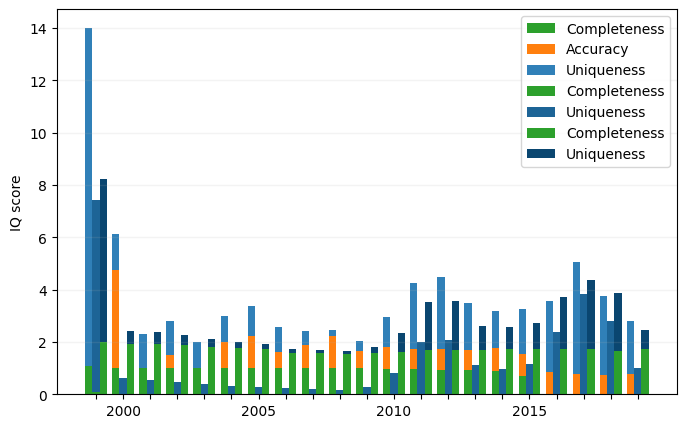

In [23]:
if 'Accuracy' in metrics_updated: 
    metrics_original['Accuracy'] = metrics_updated['Accuracy']
    del metrics_updated['Accuracy']

if 'Accuracy' in metrics_updated_all:
    del metrics_updated_all['Accuracy']

plot_stacked([metrics_original, metrics_updated, metrics_updated_all])

# Comparison

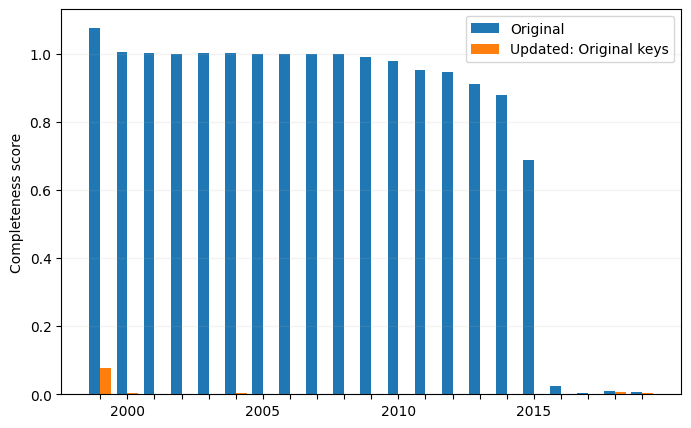

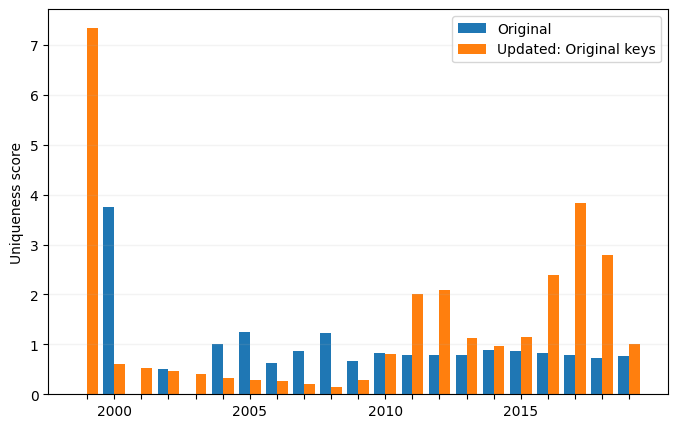

In [24]:
for (label, m_orig), (label, m_updated) in zip(metrics_original.items(), metrics_updated.items()):
    compared_metrics = {'Original': m_orig, 'Updated: Original keys': m_updated}
    side_by_side_barplot(compared_metrics, label)

## All fields

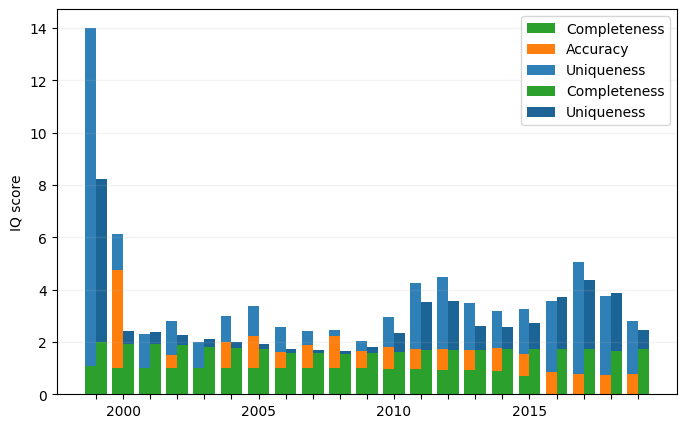

In [25]:
plot_stacked([metrics_original, metrics_updated_all])

1.1227554277607024


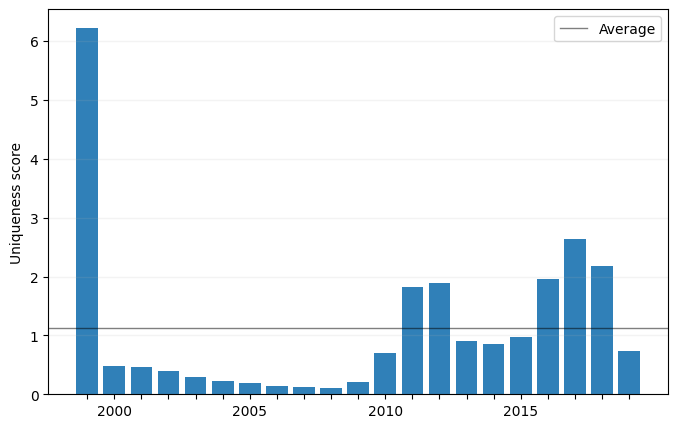

In [26]:
plot_metric(metrics_updated_all['Uniqueness'], 'Uniqueness')

### Comparing all uniqueness metrics

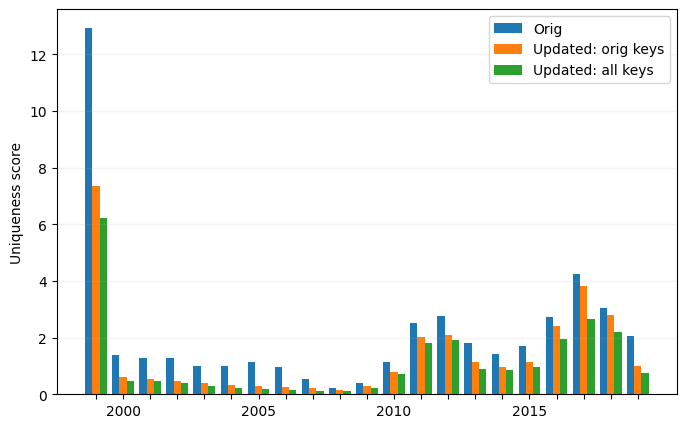

In [27]:
comparing = {
    'Orig': metrics_original['Uniqueness'],
    'Updated: orig keys': metrics_updated['Uniqueness'],
    'Updated: all keys': metrics_updated_all['Uniqueness']}
side_by_side_barplot(comparing, 'Uniqueness')

# Testing the dataset

In [28]:
from iq.uniqueness_metric import UniquenessMetric

um = UniquenessMetric(structured_fields)

clusters_year = um.build_clusters(original_db[2011])

In [29]:
biggest_cluster = max([(k, len(c)) for k, c in clusters_year.items()], key=lambda i: i[1])

print(sorted(e.id for e in clusters_year[biggest_cluster[0]]))
print(sorted(e.description for e in clusters_year[biggest_cluster[0]]))
print(biggest_cluster[0])
print(biggest_cluster[1])

['CVE-2011-0111', 'CVE-2011-0112', 'CVE-2011-0113', 'CVE-2011-0114', 'CVE-2011-0117', 'CVE-2011-0118', 'CVE-2011-0119', 'CVE-2011-0120', 'CVE-2011-0121', 'CVE-2011-0122', 'CVE-2011-0123', 'CVE-2011-0124', 'CVE-2011-0125', 'CVE-2011-0126', 'CVE-2011-0127', 'CVE-2011-0128', 'CVE-2011-0129', 'CVE-2011-0130', 'CVE-2011-0131', 'CVE-2011-0133', 'CVE-2011-0134', 'CVE-2011-0135', 'CVE-2011-0136', 'CVE-2011-0137', 'CVE-2011-0138', 'CVE-2011-0139', 'CVE-2011-0140', 'CVE-2011-0141', 'CVE-2011-0142', 'CVE-2011-0143', 'CVE-2011-0144', 'CVE-2011-0145', 'CVE-2011-0146', 'CVE-2011-0147', 'CVE-2011-0148', 'CVE-2011-0149', 'CVE-2011-0150', 'CVE-2011-0151', 'CVE-2011-0152', 'CVE-2011-0153', 'CVE-2011-0155', 'CVE-2011-0156', 'CVE-2011-0164', 'CVE-2011-0165', 'CVE-2011-0168']
[['WebKit, as used in Apple iTunes before 10.2 on Windows, allows man-in-the-middle attackers to execute arbitrary code or cause a denial of service (memory corruption and application crash) via vectors related to iTunes Store browsin

In [30]:
print(sum(1 for e in updated_entries if e.path))
print([(e.description, e.path) for e in updated_entries if e.path][:10])

25135
[(['Execute commands as root via buffer overflow in Tooltalk database server (rpc.ttdbserverd).'], {'rpc.ttdbserverd'}), (['Delete or create a file via rpc.statd, due to invalid information.'], {'rpc.statd'}), (['Arbitrary command execution via buffer overflow in Count.cgi (wwwcount) cgi-bin program.'], {'Count.cgi'}), (['root privileges via buffer overflow in login/scheme command on SGI IRIX systems.'], {'login', 'scheme', '/'}), (['Buffer overflow in lpr, as used in BSD-based systems including Linux, allows local users to execute arbitrary code as root via a long -C (classification) command line option.'], {'lpr'}), (['webdist CGI program (webdist.cgi) in SGI IRIX allows remote attackers to execute arbitrary commands via shell metacharacters in the distloc parameter.'], {'webdist.cgi'}), (['Sun/Solaris utmp file allows local users to gain root access if it is writable by users other than root.'], {'Sun', 'Solaris', '/'}), (['Buffer overflow in SunOS/Solaris ps command.'], {'Sol

In [31]:
# from matplotlib.colors import Normalize
# import matplotlib.pyplot as plt

# def plot_iq_comparison(comparing_metrics: list[dict], normalized=False):
#     for metrics in comparing_metrics:
#         years = metrics[[*metrics.keys()][0]].keys()
#         xticklabels = [y if int(y) % 5 == 0 else '' for y in years]
#         x = np.arange(len(xticklabels))

#         fig, ax = plt.subplots()
#         width = 0.8

#         offset = np.zeros(len(original_db))

#         for label,metric in metrics.items():
#             if normalized:
#                 norm = Normalize(0, max(metric.values()))
#                 data = list(map(norm, metric.values()))
#             else:
#                 data = list(metric.values())
#             ax.bar(x, data, width, bottom=offset, label=label)
#             offset += data

#         ax.set_xticks(x)
#         ax.set_xticklabels(xticklabels)
#         ax.legend()

#     fig.set_figheight(figheight)
#     fig.set_figwidth(figwidth)
    
#     plt.show()

# Attachments

In [32]:
from cvss.cvssv3 import CVSSV3 

translate_values = {
    'AV': {'N': 'NETWORK', 'A': 'ADJACENT_NETWORK', 'L': 'LOCAL', 'P': 'PHYSICAL'},
    'AC': {'L': 'LOW', 'H': 'HIGH'},
    'PR': {'N': 'NONE', 'L': 'LOW', 'H': 'HIGH'},
    'UI': {'N': 'NONE', 'R': 'REQUIRED'},
    'SC': {'C': 'CHANGED', 'U': 'UNCHANGED'},
    'CI': {'H': 'HIGH', 'L': 'LOW', 'N': 'NONE'},
    'II': {'H': 'HIGH', 'L': 'LOW', 'N': 'NONE'},
    'AI': {'H': 'HIGH', 'L': 'LOW', 'N': 'NONE'}
}

translate_keys = {
    'AV': 'attackVector',
    'AC': 'attackComplexity',
    'PR': 'privilegesRequired',
    'UI': 'userInteraction',
    'SC': 'scope',
    'CI': 'confidentialityImpact',
    'II': 'integrityImpact',
    'AI': 'availabilityImpact'
}

def _get_tags(entry: list):
    for l in entry:
        if len(l.split()) < 3:
            print(l)
            continue
        token, tags, cve_id = l.split()
        for t in tags.split(','):
            yield (t,token)

def _translate_cvss_tag(tag: str):
    parsed = {}
    for tag in cvss_tags.split(','):
        k,v = tag.split(':')
        parsed[translate_keys[k]] = translate_values[k][v]

def _parse_for_tags(entry: list):
    parsed = defaultdict(list)
    for tag, token in _get_tags(entry):
        parsed[tag].append(token)
    return parsed

def _extract_cvss_parameters(parsed_entry: dict):
    cvss_parameters = {}
    for key in [key for key in parsed_entry if ':' in key]:
        param, value = key.split(':')
        cvss_parameters[translate_keys[param]] = translate_values[param][value]
    return cvss_parameters
            
def _set_tags(nvd_entry: NVDEntry, parsed: dict):
    cvss_parameters = _extract_cvss_parameters(parsed)
    
    nvd_entry.vulnerable_function = set(parsed.get('VF', []))
    nvd_entry.vulnerable_path = set(parsed.get('VP', []))
    nvd_entry.weakness = parsed.get('W', [])
    nvd_entry.predicted_cvssv3 = CVSSV3(cvss_parameters, nvd_entry.cvssv3.__dict__ if nvd_entry.cvssv3 else None)
    
def update_db(nvd_dataset: list, predicted_entries: list):
    dataset_dict = {e.id:e for e in nvd_dataset}
    for e in predicted_entries:
        parsed = _parse_for_tags(e)
        e_id = e[0].split()[2]
        referred = dataset_dict.get(e_id)
        if referred:
            _set_tags(referred, parsed)
            yield referred

updated_nvd_entries = list(update_db(valid_entries, predicted_entries))
print(len(valid_entries),len(updated_nvd_entries))

131541 125553
